# <center> Electromyographie de Surface et applications dans la fabrications des membres artificiels<center>

In [3]:
import matplotlib.pyplot as plt
from helper import *
from scipy import signal as sg
import numpy as np
import seaborn as sns
import scipy.ndimage.filters as ndif
import time as ti
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# 1. Récuperation des données,Premiére Visualization

In [4]:
# For filenaming purposes
Fsave_dossier = "Graphs/"
Fdata = "data/" 
FangleR = "Angle réel/"
Fsignal = "Signal Capteur/"

In [5]:
# Load the data and create time axes #

## Signal Capteur ##
signal = get_single_column_data(Fdata + Fsignal + "raw1.txt")[:1800]
time = create_time_axes(signal)
size = np.size(signal)

## Angle reel ##
real = np.load(Fdata +FangleR+ "better2.npy")
time_real = np.linspace(0,7200,len(real))

## Grandeurs communes ##
totaltimeMs = 4*size # Total time 7200ms

[]

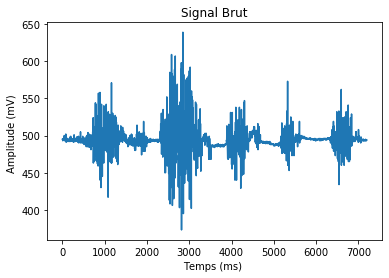

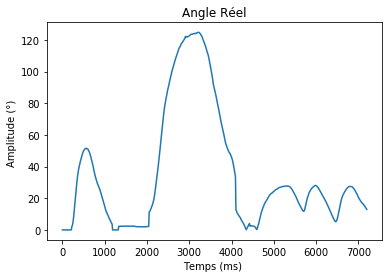

In [6]:
# Plottage # 

## Signal Brut ## 
fig,ax = plt.subplots()
ax.plot(time, signal)
ax.set_title("Signal Brut")
ax.set_xlabel("Temps (ms) ")
ax.set_ylabel("Amplitude (mV) ")
plt.savefig(Fsave_dossier + "Raw Signal.jpeg",dpi=1200)


## Angle Reel ## 
fig1,ax1 = plt.subplots()
plt.plot(time_real, real)
ax1.set_title("Angle Réel")
ax1.set_xlabel("Temps (ms) ")
ax1.set_ylabel("Amplitude (°) ")
plt.savefig(Fsave_dossier + "Real angle.jpeg",dpi=1200)


plt.plot()


# 2. Redressement

Le signal est d'abord recentré autour de 0 puis on prend la valuer absolue.
Il est nécessaire de faire cette etape sinon le filtrage d'apres ne sera pas efficafe car la valeur moyenne des pics du signal sont presque nulles.
Un filtre passe haut pourrait eventuellement être utilisé pour eliminer des bruits


In [9]:
rms = np.sqrt(np.mean(signal**2))
centered_signal = signal-rms
rectified_signal = np.abs(signal-rms)

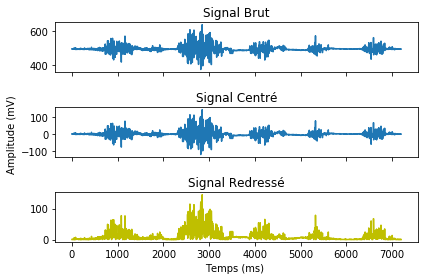

In [10]:
fig2, (ax1, ax2,ax3) = plt.subplots(3,sharex=True)
ax1.plot(time, signal)
ax2.plot(time,centered_signal)
ax3.plot(time, rectified_signal,'y')
ax1.set_title("Signal Brut")
ax2.set_title("Signal Centré")
ax3.set_title("Signal Redressé")
ax3.set_xlabel("Temps (ms) ")
ax2.set_ylabel("Amplitude (mV) ")
fig2.tight_layout()

plt.savefig(Fsave_dossier  + "a.jpeg", dpi=1200)


# 2. Reconsitution d'enveloppe


## 2.1 Moyenne Glissante

### Introduction

In [11]:
def moving_average(rectified_signal,Tw = 50):
    return np.convolve(rectified_signal,np.ones(Tw)/float(Tw), "valid")

def normalization(signal):
    vmax = 120
    return rectified_signal / vmax

--- 0.0006413459777832031 seconds ---


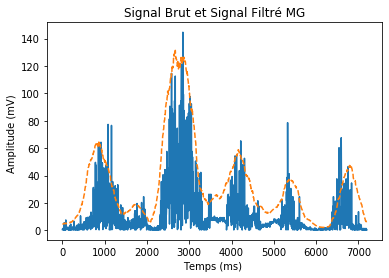

In [12]:


import time as ti
start_time = ti.time()

output = moving_average(rectified_signal, 88)*3
print("--- %s seconds ---" % (ti.time() - start_time))

fig,ax = plt.subplots()

ax.plot(time, rectified_signal)
ax.plot(np.linspace(0,7200,len(output)) , output, '--')
ax.set_title("Signal Brut et Signal Filtré MG")
ax.set_xlabel("Temps (ms) ")
ax.set_ylabel("Amplitude (mV) ")
plt.plot()
plt.savefig(Fsave_dossier + "Signal Filre MG et Brut.jpeg",dpi=1200)

### Etude du paramètre

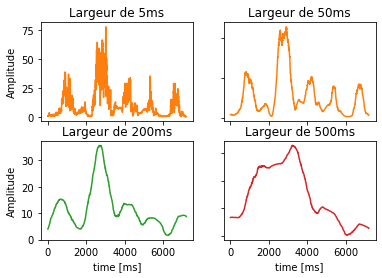

In [13]:
largeurs = [5,50,200,500]
fig, axs = plt.subplots(2, 2)
output= [[]]
i=0
name = "Largeur de "
unite = "ms"

for coup in largeurs:
    
    output.append(moving_average(rectified_signal,Tw = coup))
    i+=1

axs[0, 0].plot(np.linspace(0,7200,len(output[1])), output[1], 'tab:orange') 
axs[0, 0].set_title(name + str(largeurs[0]) + unite)
axs[0, 1].plot(np.linspace(0,7200,len(output[2])), output[2], 'tab:orange')
axs[0, 1].set_title(name + str(largeurs[1]) + unite)
axs[1, 0].plot(np.linspace(0,7200,len(output[3])), output[3], 'tab:green')
axs[1, 0].set_title(name + str(largeurs[2]) + unite)
axs[1, 1].plot(np.linspace(0,7200,len(output[4])), output[4], 'tab:red')
axs[1, 1].set_title(name + str(largeurs[3]) + unite)

for ax in axs.flat:
    ax.set(xlabel='time [ms]', ylabel='Amplitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig(Fsave_dossier + "MG Etude params.png", dpi=1200)

### Filtre passe bas numérique

In [66]:
def butter(signal,f = 8, N=6):
    lp = sg.butter(N, f, 'lp', fs=1000, output='sos',)
    return sg.sosfiltfilt(lp,signal)

--- 0.0060727596282958984 seconds ---


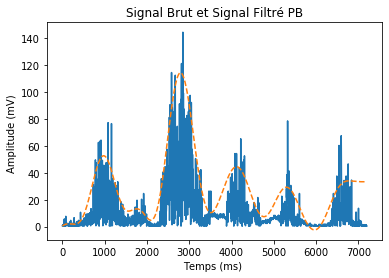

In [89]:
start_time = ti.time()

output = butter(rectified_signal,f = 5, N=6)
print("--- %s seconds ---" % (ti.time() - start_time))

fig,ax = plt.subplots()

ax.plot(time, rectified_signal)
# ax.plot(time,rectified_signal,20)
ax.plot(time, output*2.5,"--")
ax.set_title("Signal Brut et Signal Filtré PB")
ax.set_xlabel("Temps (ms) ")
ax.set_ylabel("Amplitude (mV) ")
plt.plot()
plt.savefig(Fsave_dossier + "Signal Filre PB et Brut.jpeg",dpi=1200)


### Etude du paramètre

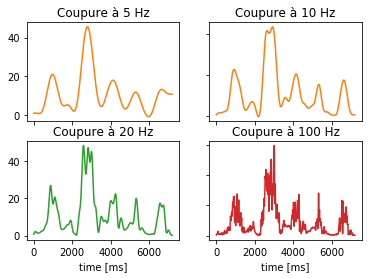

In [68]:
coupures = [5,10,20,100]
fig, axs = plt.subplots(2, 2)
output= np.zeros((4,size))
i=0
name = "Coupure à "

unite = " Hz"

for coup in coupures:
    lp = sg.butter(5, coup, 'lp', fs=1000, output='sos')
    output[i] = sg.sosfiltfilt(lp,rectified_signal)
    i+=1

axs[0, 0].plot(time, output[0], 'tab:orange') 
axs[0, 0].set_title(name + str(coupures[0]) + unite)
axs[0, 1].plot(time, output[1], 'tab:orange')
axs[0, 1].set_title(name + str(coupures[1]) + unite)
axs[1, 0].plot(time, output[2], 'tab:green')
axs[1, 0].set_title(name + str(coupures[2]) + unite)
axs[1, 1].plot(time, output[3], 'tab:red')
axs[1, 1].set_title(name + str(coupures[3]) + unite)

for ax in axs.flat:
#     ax.set(xlabel='time [ms]', ylabel='Amplitude')
    ax.set(xlabel='time [ms]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.savefig(Fsave_dossier + "Signal Filre PB  params.jpeg",dpi=1200)    

# RMS

In [69]:
def rms(signal,Tw):
    a2 = np.power(signal,2)
    window = np.ones(Tw)/float(Tw)
    return np.sqrt(np.convolve(a2, window, 'valid'))

def normalization(signal):
    vmax = 120
    return rectified_signal / vmax

In [70]:
len(rms(rectified_signal,5))

1796

--- 0.0004894733428955078 seconds ---


[]

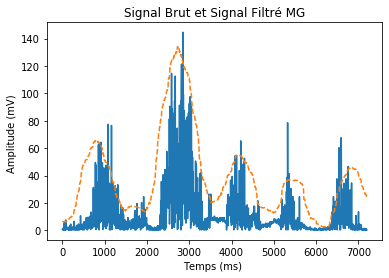

In [71]:
import time as ti
start_time = ti.time()

output = rms(rectified_signal, 120)*2.5
print("--- %s seconds ---" % (ti.time() - start_time))

fig,ax = plt.subplots()

ax.plot(time, rectified_signal)
ax.plot(np.linspace(0,7200,len(output)) , output, '--')
ax.set_title("Signal Brut et Signal Filtré MG")
ax.set_xlabel("Temps (ms) ")
ax.set_ylabel("Amplitude (mV) ")
plt.plot()

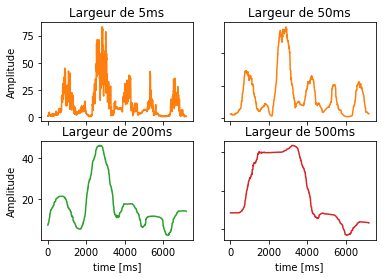

In [72]:
largeurs = [5,50,200,500]
fig, axs = plt.subplots(2, 2)
output= [[]]
i=0
name = "Largeur de "
unite = "ms"

for coup in largeurs:
    
    output.append(rms(rectified_signal,Tw = coup))
    i+=1

axs[0, 0].plot(np.linspace(0,7200,len(output[1])), output[1], 'tab:orange') 
axs[0, 0].set_title(name + str(largeurs[0]) + unite)
axs[0, 1].plot(np.linspace(0,7200,len(output[2])), output[2], 'tab:orange')
axs[0, 1].set_title(name + str(largeurs[1]) + unite)
axs[1, 0].plot(np.linspace(0,7200,len(output[3])), output[3], 'tab:green')
axs[1, 0].set_title(name + str(largeurs[2]) + unite)
axs[1, 1].plot(np.linspace(0,7200,len(output[4])), output[4], 'tab:red')
axs[1, 1].set_title(name + str(largeurs[3]) + unite)

for ax in axs.flat:
    ax.set(xlabel='time [ms]', ylabel='Amplitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig(Fsave_dossier + "RMS Etude params.png", dpi=1200)

# 3. Reconsitution de l'angle

In [90]:
outputpb = butter(rectified_signal,f = 8, N=6)
outputmg = moving_average(rectified_signal, 88)
outputrms = rms(rectified_signal, 88)

In [91]:
def normalization(signal,maxval):
    return signal/maxval

In [92]:
npb = normalization(outputpb,60)*150
nmg = normalization(outputmg,60)*150
nrms = normalization(outputrms,60)*150

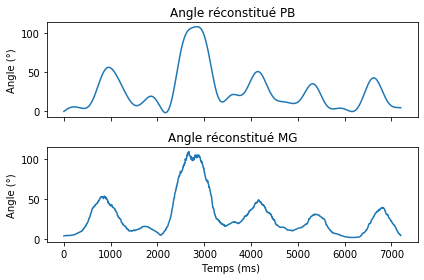

In [93]:
fig2, (ax1, ax2) = plt.subplots(2,sharex=True)
ax1.plot(time, npb)
ax1.set_title("Angle réconstitué PB")
ax2.plot(np.linspace(0,7200,len(nmg)),nmg)
ax2.set_title("Angle réconstitué MG")
ax2.set_xlabel("Temps (ms) ")
ax2.set_ylabel("Angle (°)")

# ax3.plot(np.linspace(0,7200,len(nrms)),nrms)
# ax3.set_title("Angle réconstitué RMS")
# ax3.set_xlabel("Temps (ms) ")
# ax3.set_ylabel("Angle (°)")

ax1.set_ylabel("Angle (°)")
fig2.tight_layout()

plt.savefig(Fsave_dossier + "Signal Filre PB et MG et RMS.jpeg",dpi=1200)

# 4. Etude des Paramètres

## Fidelité

In [77]:
def phi(real,filt):
    return np.sum(np.sqrt((real - filt)**2))

def index_array(signal, real):
    idx = np.round(np.linspace(0, len(signal) - 1, len(real))).astype(int)
    return signal[idx]

def fidelite(real,filt,func = False):
    max1 =np.sqrt((np.max(filt)-np.min(real))**2)
    
    max2 = np.sqrt((np.max(real)-np.min(filt))**2)
    norm = max(max1,max2)
    phi = np.sqrt((real - filt)**2)
    if func:
        return 100*phi/norm
    return 100-100*np.sum(phi)/(norm*len(real)) 

def var_totale(signal):
    return np.sum(np.abs(np.ediff1d(signal)))


In [78]:
fidelite(index_array(nmg, real), real)

83.69425403971829

In [79]:
lphimg = []
lphipb = []
varmg = []
varpb = []

boundaries_mg = [1,500]
boundaries_pb = [1,100]
for tw in range(boundaries_mg[0],boundaries_mg[1]):
    lphimg.append(phi(real,index_array(150*normalization(moving_average(rectified_signal, tw),60), real)))
    varmg.append(var_totale(moving_average(rectified_signal, tw)))
    
for coup in range(boundaries_pb[0],boundaries_pb[1]):
    lphipb.append(phi(real,index_array(150*normalization(butter(rectified_signal, coup),60), real)))
    varpb.append(var_totale(butter(rectified_signal, coup)))

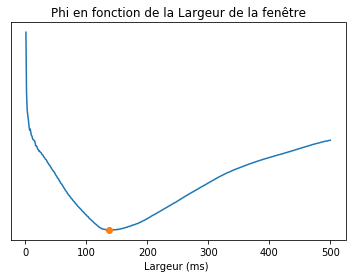

In [80]:
fig,ax = plt.subplots()
ax.plot(np.linspace(boundaries_mg[0],boundaries_mg[1],len(lphimg)) , np.array(lphimg))
ax.plot(np.argmin(lphimg) , lphimg[np.argmin(lphimg)] ,'o')
ax.set_title("Phi en fonction de la Largeur de la fenêtre")
ax.set_xlabel("Largeur (ms) ")
ax.axes.yaxis.set_visible(False)
plt.plot()
plt.savefig(Fsave_dossier + "Phi MG.jpeg",dpi=1200)

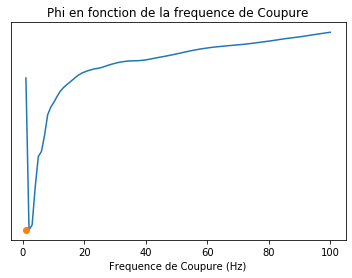

In [81]:
fig,ax = plt.subplots()
ax.plot(np.linspace(boundaries_pb[0],boundaries_pb[1],len(lphipb)) , np.array(lphipb))
ax.plot(np.argmin(lphipb) , lphipb[np.argmin(lphipb)] ,'o')
ax.set_title("Phi en fonction de la frequence de Coupure")
ax.set_xlabel("Frequence de Coupure (Hz)")
ax.axes.yaxis.set_visible(False)
plt.plot()
plt.savefig(Fsave_dossier + "Phi PB.jpeg",dpi=1200)

In [82]:
np.argmin(lphipb)

1

## Variation totale

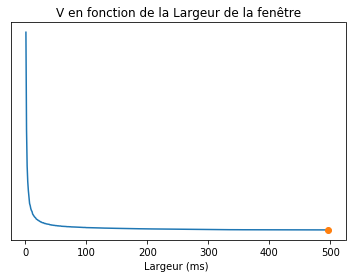

In [83]:
fig,ax = plt.subplots()
ax.plot(np.linspace(boundaries_mg[0],boundaries_mg[1],len(varmg)) , np.array(varmg))
ax.plot(np.argmin(varmg) , varmg[np.argmin(varmg)] ,'o')
ax.set_title("V en fonction de la Largeur de la fenêtre")
ax.set_xlabel("Largeur (ms) ")
ax.axes.yaxis.set_visible(False)
plt.plot()
plt.savefig(Fsave_dossier + "V MG.jpeg",dpi=1200)

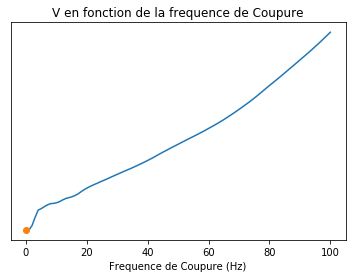

In [84]:
fig,ax = plt.subplots()
ax.plot(np.linspace(boundaries_pb[0],boundaries_pb[1],len(varpb)) , np.array(varpb))
ax.plot(np.argmin(varpb) , varpb[np.argmin(varpb)] ,'o')
ax.set_title("V en fonction de la frequence de Coupure")
ax.set_xlabel("Frequence de Coupure (Hz)")
ax.axes.yaxis.set_visible(False)
plt.plot()
plt.savefig(Fsave_dossier + "V PB.jpeg",dpi=1200)

# En conclusion

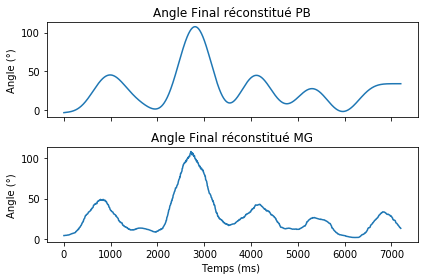

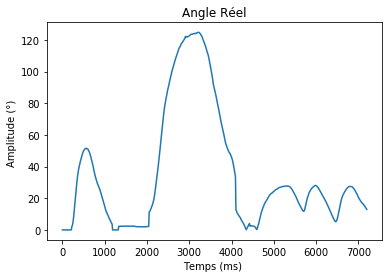

In [97]:
outputpb = butter(rectified_signal,f = 4, N=6)
outputmg = moving_average(rectified_signal, 125)
npb = normalization(outputpb,60)*150
nmg = normalization(outputmg,60)*150

fig2, (ax1, ax2) = plt.subplots(2,sharex=True)
ax1.plot(time, npb)
ax1.set_title("Angle Final réconstitué PB")
ax2.plot(np.linspace(0,7200,len(nmg)),nmg)
ax2.set_title("Angle Final réconstitué MG")
ax2.set_xlabel("Temps (ms) ")
ax2.set_ylabel("Angle (°)")


ax1.set_ylabel("Angle (°)")
fig2.tight_layout()

plt.savefig(Fsave_dossier + "Signal Final PB et MG .jpeg",dpi=1200)


fig1,ax1 = plt.subplots()
plt.plot(time_real, real)
ax1.set_title("Angle Réel")
ax1.set_xlabel("Temps (ms) ")
ax1.set_ylabel("Amplitude (°) ")
plt.savefig(Fsave_dossier + "Real angle.jpeg",dpi=1200)

In [87]:
fidelite(index_array(npb, real), real)

82.46466781256986

In [88]:
fidelite(index_array(nmg, real), real)

84.75064478680852